In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

# Function to load data and labels
def load_data_and_labels(sector_number):
    base_path = f'/kaggle/input/sector{sector_number}'
    galaxy_folder = os.path.join(base_path, 'Augmented_Galaxy_Images', 'Augmented_Galaxy_Images')
    star_folder = os.path.join(base_path, 'Augmented_Star_Images', 'Augmented_Star_Images')
    
    # Adjust file names based on sector
    if sector_number == 16:
        galaxy_csv = os.path.join(base_path, f'galaxys_s{sector_number}.csv')
        star_csv = os.path.join(base_path, f'stars_s{sector_number}.csv')
    elif sector_number == 10:
        galaxy_csv = os.path.join(base_path, f'galaxys_s{sector_number}_200.csv')
        star_csv = os.path.join(base_path, f'stars_s{sector_number}_200.csv')
    elif sector_number == 7:
        galaxy_csv = os.path.join(base_path, f'galaxy_s{sector_number}.csv')
        star_csv = os.path.join(base_path, f'stars_s{sector_number}.csv')
    elif sector_number == 13:
        galaxy_csv = os.path.join(base_path, f'galaxy_s{sector_number}.csv')
        star_csv = os.path.join(base_path, f'star_s{sector_number}.csv')

        
    # Load metadata from CSV files to ensure correct labeling
    galaxy_metadata = pd.read_csv(galaxy_csv, skiprows=1)
    star_metadata = pd.read_csv(star_csv, skiprows=1)

    images = []
    labels = []  # 0 for star, 1 for galaxy

    def extract_objid(filename):
        return filename.split('_')[-1].split('.')[0]

    for file in os.listdir(galaxy_folder):
        if file.endswith('.npy'):
            objid = extract_objid(file)
            if any(galaxy_metadata['objid'].astype(str) == objid):
                img = np.load(os.path.join(galaxy_folder, file))
                images.append(img)
                labels.append(1)

    for file in os.listdir(star_folder):
        if file.endswith('.npy'):
            objid = extract_objid(file)
            if any(star_metadata['objid'].astype(str) == objid):
                img = np.load(os.path.join(star_folder, file))
                images.append(img)
                labels.append(0)

    return np.array(images), np.array(labels)

# Load data from training sectors (10 and 16)
images10, labels10 = load_data_and_labels(10)
images16, labels16 = load_data_and_labels(16)
images13, labels13 = load_data_and_labels(13)

# Combine the data from the two training sectors
X_train = np.concatenate((images10, images16, images13))
y_train = np.concatenate((labels10, labels16, labels13))

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(45, 45, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification layer 
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Ensure labels are in the correct shape for binary_crossentropy
y_train = y_train.flatten()
y_val = y_val.flatten()

# Train the CNN
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Load test data from sector 7
X_test, y_test = load_data_and_labels(7)
y_test = y_test.flatten()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 32)        1472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

313/313 [==============================] - 5s 14ms/step


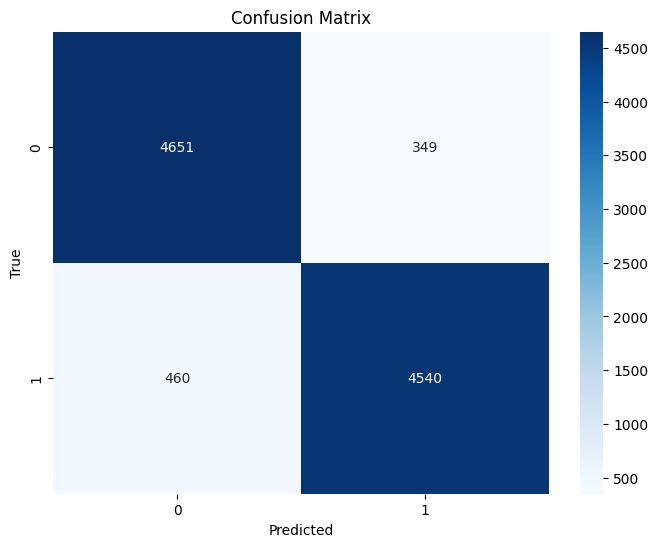

              precision    recall  f1-score   support

        Star       0.91      0.93      0.92      5000
      Galaxy       0.93      0.91      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Test Accuracy: 0.9190999865531921, Test Loss: 0.30605387687683105


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Star', 'Galaxy'])
print(report)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")